In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 5.1 MB/s 
     |████████████████████████████████| 197 kB 68.4 MB/s 
     |████████████████████████████████| 4.2 MB 36.6 MB/s 
     |████████████████████████████████| 346 kB 72.3 MB/s 
     |████████████████████████████████| 1.2 MB 56.8 MB/s 
     |████████████████████████████████| 59 kB 8.9 MB/s 
     |████████████████████████████████| 1.1 MB 25.6 MB/s 
     |████████████████████████████████| 140 kB 73.8 MB/s 
     |████████████████████████████████| 86 kB 7.5 MB/s 
     |████████████████████████████████| 212 kB 57.0 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 67.8 MB/s 
     |████████████████████████████████| 127 kB 70.6 MB/s 
     |████████████████████████████████| 271 kB 71.4 MB/s 
     |████████████████████████████████| 144 kB 70.1 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 6.6 MB 47.4 MB/s 
ERROR: pip's dependency

In [2]:
from fastbook import *

#  Key point model

 A key point refers to a specific location represented in an image—in this case, we'll use images of people and we'll be looking for the center of the person's face in each image.

## Data

[Biwi Kinect Head Pose dataset](https://icu.ee.ethz.ch/research/datsets.html)

In [3]:
# downloading data set #
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
path

Path('/root/.fastai/data/biwi_head_pose')

In [5]:
Path.BASE_PATH = path

In [6]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

There are 24 directories numbered from 01 to 24 (they correspond to the different people photographed), and a corresponding *.obj* file for each (we won't need them here). Let's take a look inside one of these directories:

Each of the 24 directories corresponds to a different photographed person.*1000 photos for the first person*
```python
(path/"01").ls().sorted()
```

In [7]:
(path/"01").ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [8]:
(path/"02").ls().sorted()

(#1024) [Path('02/depth.cal'),Path('02/frame_00003_pose.txt'),Path('02/frame_00003_rgb.jpg'),Path('02/frame_00004_pose.txt'),Path('02/frame_00004_rgb.jpg'),Path('02/frame_00005_pose.txt'),Path('02/frame_00005_rgb.jpg'),Path('02/frame_00006_pose.txt'),Path('02/frame_00006_rgb.jpg'),Path('02/frame_00007_pose.txt')...]

convert image filename to its associated pose file

In [9]:
test = get_image_files(path)

In [10]:
test[0]

Path('24/frame_00111_rgb.jpg')

In [11]:
len(test)

15678

In [12]:
# test image path #
test[0]

Path('24/frame_00111_rgb.jpg')

In [13]:
# image path to string #
str(test[0])

'/root/.fastai/data/biwi_head_pose/24/frame_00111_rgb.jpg'

In [14]:
# remove 'rgb.jpg' from string path #
str(test[0])[:-7]

'/root/.fastai/data/biwi_head_pose/24/frame_00111_'

In [15]:
# concate 'pose.txt' to image path string #
f"{str(test[0])[:-7]}pose.txt"

'/root/.fastai/data/biwi_head_pose/24/frame_00111_pose.txt'

In [16]:
# revert path string back to path #
Path(f"{str(test[0])[:-7]}pose.txt")

Path('24/frame_00111_pose.txt')

**All above in one function**

In [17]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('24/frame_00111_pose.txt')

Look at image

In [18]:
# first image #
im = PILImage.create(img_files[0])
im.shape

(480, 640)

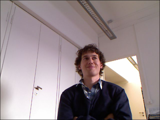

In [19]:
im.to_thumb(160)

The Biwi dataset website used to explain the format of the pose text file associated with each image, which shows the location of the center of the head. The details of this aren't important for our purposes, so we'll just show the function we use to extract the head center point:

In [20]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

This function returns the coordinates as a tensor of two items:

In [21]:
get_ctr(img_files[0])

tensor([382.9565, 240.3137])

### DataBlock

We can use the above function for getting our y value`(label)`.
```python
get_y = get_ctr
```

In [22]:
# for splitter we dont want the same person #
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

**Making data set**

In [23]:
dset = biwi.datasets(path)

In [24]:
len(dset)

15678

In [25]:
dset.train[0]

(PILImage mode=RGB size=640x480, TensorPoint([[382.9565, 240.3137]]))

In [26]:
dset.valid[0]

(PILImage mode=RGB size=640x480, TensorPoint([[380.2917, 226.0414]]))

In [27]:
x,y = dset.train[0]
x.shape, y.shape

((480, 640), torch.Size([1, 2]))

### dataloaders

In [28]:
dls = biwi.dataloaders(path)


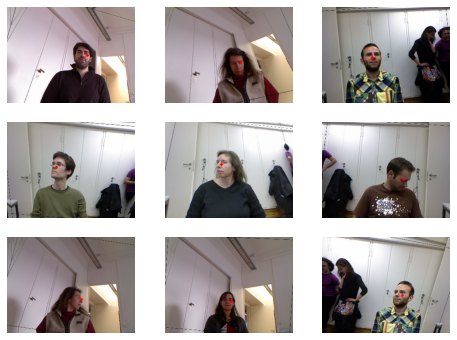

In [29]:
dls.train.show_batch(max_n=9, figsize=(8,6))

In [30]:
xb,yb = dls.train.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [31]:
# output of 1 label in batch #
yb[0]

TensorPoint([[ 0.0792, -0.2427]], device='cuda:0')

## Train Model

`y_range` tells fastai the range of our targets.(*coordinates in fastai and PyTorch are always rescaled between -1 and +1*)

In [32]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [33]:
# loss func #
learn.loss_func

FlattenedLoss of MSELoss()

In [34]:
learn.opt_func

<function fastai.optimizer.Adam>

In [35]:
learn.metrics

(#0) []

**choose lr**

SuggestedLRs(valley=0.0010000000474974513)

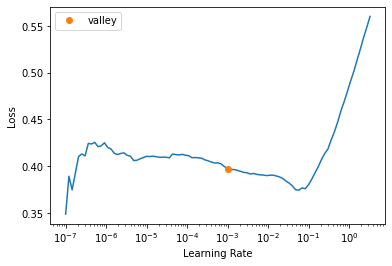

In [37]:
learn.lr_find()

In [41]:
lr = 1e-3
# fit model #
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.226051,0.028099,02:06


epoch,train_loss,valid_loss,time
0,0.086321,0.002315,02:23
1,0.019417,0.000658,02:21
2,0.010858,0.000797,02:20


In [42]:
# RMSE #
math.sqrt(0.0007)

0.026457513110645904

**change learning rate**

In [44]:
learn2 = cnn_learner(dls, resnet18, y_range=(-1,1))

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [45]:
lr = 1e-2
# fit model #
learn2.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.047435,0.014930,02:07


epoch,train_loss,valid_loss,time
0,0.007526,0.004074,02:21
1,0.002727,0.000375,02:20
2,0.001441,0.000056,02:21


In [46]:
# RMSE #
math.sqrt(0.000056)

0.0074833147735478825

learn2 is more accurate

**View results from training**

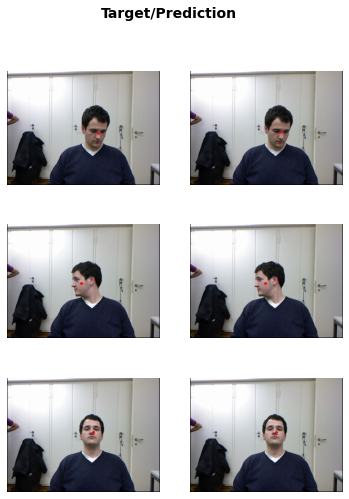

In [47]:
learn2.show_results(ds_idx=1, nrows=3, figsize=(6,8))

## Export model

In [53]:
learn2.export(fname='Image_center_regress2.pkl')

In [54]:
# check if model exits #
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('Image_center_regress.pkl'),Path('Image_center_regress2.pkl')]

## Model Prediction

In [52]:
# test image path #
test_path1 = "/content/SAM_0205.JPG"
test_path2 = "/content/SAM_0218.JPG"
test_path3 = "/content/SAM_0219.JPG"
test_path4 = "/content/SAM_0398.jpg"

In [55]:
learn2.predict(test_path1)

(TensorPoint([[147.6671, 112.2834]]),
 TensorBase([-0.0771, -0.0643]),
 TensorBase([-0.0771, -0.0643]))

In [58]:
learn2.predict(test_path2)

(TensorPoint([[159.0310, 113.0816]]),
 TensorBase([-0.0061, -0.0577]),
 TensorBase([-0.0061, -0.0577]))

In [62]:
learn2.predict(test_path2)[0]

TensorPoint([[159.0310, 113.0816]])

In [59]:
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [60]:
outm = learn2.model(xb)
outm.shape,yb.shape

(torch.Size([64, 2]), torch.Size([64, 1, 2]))

**N:B the images were in the form 'pose.txt', so make the input image into that function `img_files`**

In [66]:
test_path1_pose = img2pose(test_path1)

In [72]:
test_path1_pose

Path('/content/SAM_0pose.txt')

In [67]:
# view test image #
im = PILImage.create(test_path1)
im.shape

(4608, 3456)

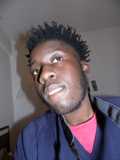

In [68]:
im.to_thumb(160)

In [70]:
# get tensor for cente of image #
# get_ctr(test_path1)
# ## we dont need to do this since we are looking for a prediction ##

In [73]:
pose_test = "/content/SAM_0205pose.txt"

In [74]:
# prediction with pose #
learn2.predict(pose_test)

(TensorPoint([[147.6671, 112.2834]]),
 TensorBase([-0.0771, -0.0643]),
 TensorBase([-0.0771, -0.0643]))

In [75]:
learn2.predict(test_path1)

(TensorPoint([[147.6671, 112.2834]]),
 TensorBase([-0.0771, -0.0643]),
 TensorBase([-0.0771, -0.0643]))

**N.B. Model automatically changes image to pose.txt format**

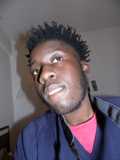

In [77]:
im.to_thumb(160)

In [78]:
learn2.predict(test_path1)

(TensorPoint([[147.6671, 112.2834]]),
 TensorBase([-0.0771, -0.0643]),
 TensorBase([-0.0771, -0.0643]))

**How do we add the predicted center mark to the new image?**

In [81]:
learn2.predict(test_path1)

(TensorPoint([[147.6671, 112.2834]]),
 TensorBase([-0.0771, -0.0643]),
 TensorBase([-0.0771, -0.0643]))

In [87]:
im = PILImage.create(test_path1)
im.shape

(4608, 3456)

In [89]:
im = im.resize((320,240))

In [90]:
im.shape

(240, 320)

In [92]:
learn2.predict(PILImage(im))

(TensorPoint([[148.9188, 113.0122]]),
 TensorBase([-0.0693, -0.0582]),
 TensorBase([-0.0693, -0.0582]))

In [93]:
results = learn2.predict(PILImage(im))
results

(TensorPoint([[148.9188, 113.0122]]),
 TensorBase([-0.0693, -0.0582]),
 TensorBase([-0.0693, -0.0582]))

In [95]:
results[0][0]

TensorPoint([148.9188, 113.0122])

In [96]:
point = results[0][0]

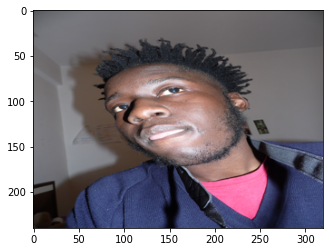

In [97]:
plt.imshow(im, zorder=1)

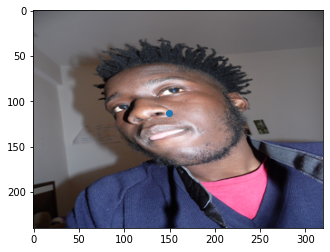

In [99]:
plt.imshow(im, zorder=1)
plt.scatter(point[0], point[1], zorder=2)
plt.show()

## App

In [103]:
def predictResized(image):
  image = PILImage(image.resize((320, 240)))
  results = learn2.predict(image)
  print(results)
  point = results[0][0]
  plt.imshow(image, zorder=1)
  plt.scatter(point[0], point[1], zorder=2)
  plt.show()

In [84]:
from ipywidgets import widgets

In [85]:
uploader = widgets.FileUpload()

(TensorPoint([[148.9188, 113.0122]]), TensorBase([-0.0693, -0.0582]), TensorBase([-0.0693, -0.0582]))


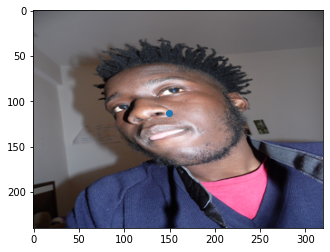

In [104]:
predictResized(im)

(TensorPoint([[148.9188, 113.0122]]), TensorBase([-0.0693, -0.0582]), TensorBase([-0.0693, -0.0582]))


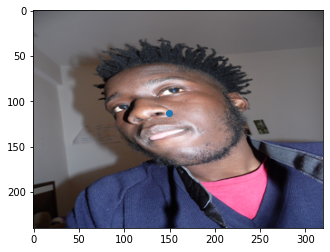

In [105]:
predictResized(PILImage.create(test_path1))

In [107]:
predictResized(test_path1)

AttributeError: ignored

**Improved predict function:**

So we just send it an image path

In [110]:
def predictResized2(image):
  image = PILImage.create(image)
  image = PILImage(image.resize((320, 240)))
  results = learn2.predict(image)
  print(results)
  point = results[0][0]
  plt.imshow(image, zorder=1)
  plt.scatter(point[0], point[1], zorder=2)
  plt.show()

(TensorPoint([[148.9188, 113.0122]]), TensorBase([-0.0693, -0.0582]), TensorBase([-0.0693, -0.0582]))


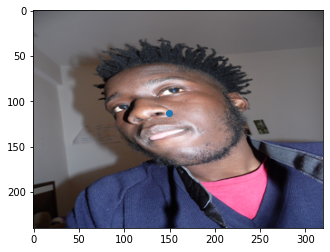

In [111]:
predictResized2(test_path1)